In [2]:
import gc_turbulence as g
%matplotlib inline

index = 'r14_01_14a'

cache_path = g.default_processed + index + '.hdf5'
r = g.ProcessedRun(cache_path=cache_path)

/nfs/see-fs-02_users/eeaol/src/anaconda/envs/thesis/lib/python2.7/site-packages/matplotlib/__init__.py:1312: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
fnames = !ls /nfs/see-fs-02_users/eeaol/lab/data/flume2/main_data/processed
paths = [g.default_processed + f for f in fnames]
runs = [g.ProcessedRun(cache_path=path) for path in paths]

In [12]:
sub_runs = [r for r in runs if '_09' in r.index]
sub_runs.pop(0).index

'r13_12_09a'

Amazingly, it looks like a component of the signal is shared between runs with the same effective gravity. 

Theories: 

- instrument 
- PIV algorithm
- tank wobbling from lock release

In [14]:
def get_signal(r):
    r.dt = 0.01
    r.ft = r.ft[...]
    transformer = g.turbulence.FrontTransformer(r)
    print "made transform"
    uf = transformer.to_front(r.U, order=0)
    print "transformed to front"
    # compute mean from uf
    mean_uf = np.mean(uf, axis=1, keepdims=True)
    # expand mean over all x
    full_mean_uf = np.repeat(mean_uf, uf.shape[1], axis=1)
    # transform to lab frame
    trans_mean_uf = transformer.to_lab(full_mean_uf, order=0)
    print "transformed to lab"
    # subtract mean current from lab frame
    mean_sub_u = r.U[...] - trans_mean_uf

    # from which we might be able to get the wave signal,
    # using the fact that it is homogeneous in x and z in the lab frame
    return np.mean(np.mean(mean_sub_u, axis=0), axis=0)

In [44]:
def get_signals(runs):
    signals = []
    for run in runs:
        print "getting ", run.index
        signal = get_signal(run)
        signal[np.isnan(signal)] = 0
        signals.append(signal)
    return signals

In [ ]:
signals = get_signals(sub_runs)

In [45]:
runs14 = [r for r in runs if '_14' in r.index]

signals14 = get_signals(runs14)

getting  r14_01_14a
made transform
transformed to front
transformed to lab
getting  r14_01_14b
made transform
transformed to front
transformed to lab
getting  r14_01_14c
made transform
transformed to front
transformed to lab
getting  r14_01_14d
made transform
transformed to front
transformed to lab
getting  r14_01_14e
made transform
transformed to front
transformed to lab
getting  r14_01_14f
made transform
transformed to front
transformed to lab


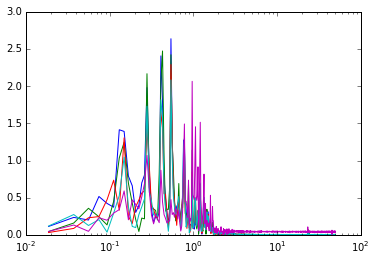

In [43]:
for signal in signals:
    fft = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(signal.size, d=0.01)
    plt.semilogx(freqs, np.abs(fft))

(0.7, 3)

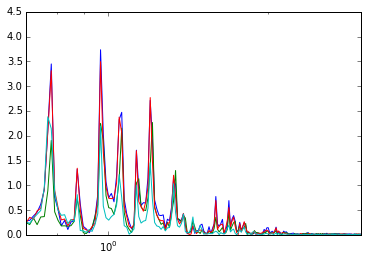

In [60]:
for signal in signals14[:-2]:
    fft = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(signal.size, d=0.01)
    plt.semilogx(freqs, np.abs(fft))
    
plt.xlim(0.7, 3)

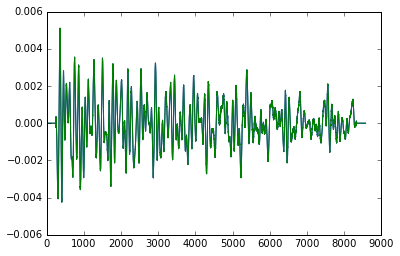

In [69]:
mean_fft = np.fft.rfft(signals14[:-2], axis=-1).mean(axis=0)
fft_mean_signal = np.fft.irfft(mean_fft)
mean_signal = np.mean(signals14[:-2], axis=0)

plt.plot(mean_signal)
plt.plot(fft_mean_signal)

We want to filter out the long waves and just focus on the cluster around 1Hz.

(40, 50)

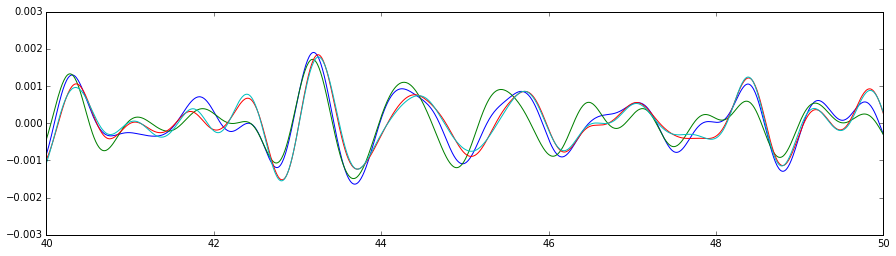

In [52]:
def filter_signals(signals):
    fsignals = []
    for signal in signals[:-1]:
        fft = np.fft.rfft(signal)
        freqs = np.fft.rfftfreq(signal.size, d=0.01)
        fft[freqs < 0.7] = 0
        fft[freqs > 3] = 0
        fsignals.append(np.fft.irfft(fft, n=signal.size))
    return fsignals

fignals = filter_signals(signals)
time = sub_runs[0].T[0, 0]

plt.figure(figsize=(15, 4))
for fsignal in fsignals:
    plt.plot(time, fsignal)
    
plt.xlim(40, 50)

(40, 50)

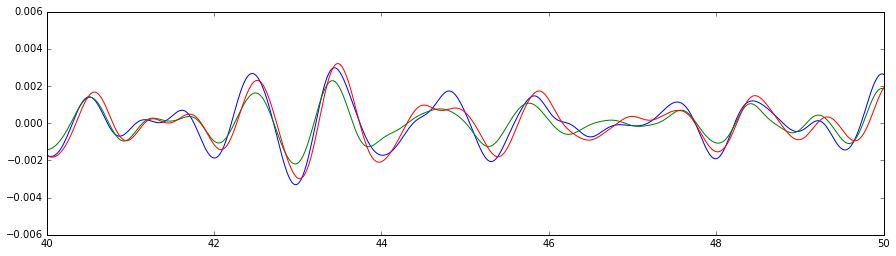

In [70]:
fsignals14 = filter_signals(signals14)
time14 = [r.T[0, 0] for r in runs14]

plt.figure(figsize=(15, 4))
for time, fsignal in zip(time14, fsignals14)[:-2]:
    plt.plot(time, fsignal)
    
plt.xlim(40, 50)

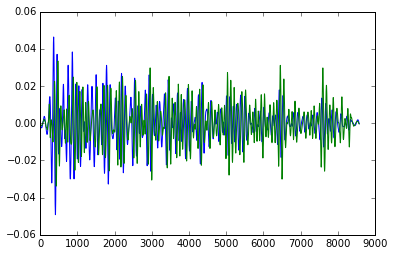

In [90]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=2)

S = np.c_[fsignals14]

X = ica.fit_transform(S.T)

plt.plot(X)

TODO: Try the ICA using the whole x, z field. Each x, z is one of the input signals. This gives ~10000 input signals.

In [93]:
    r.dt = 0.01
    r.ft = r.ft[...]
    transformer = g.turbulence.FrontTransformer(r)
    print "made transform"
    uf = transformer.to_front(r.U, order=0)
    print "transformed to front"
    # compute mean from uf
    mean_uf = np.mean(uf, axis=1, keepdims=True)
    # expand mean over all x
    full_mean_uf = np.repeat(mean_uf, uf.shape[1], axis=1)
    # transform to lab frame
    trans_mean_uf = transformer.to_lab(full_mean_uf, order=0)
    print "transformed to lab"
    # subtract mean current from lab frame
    mean_sub_u = r.U[...] - trans_mean_uf

made transform
transformed to front
transformed to lab


<matplotlib.colorbar.Colorbar instance at 0x2ae6b227ce18>

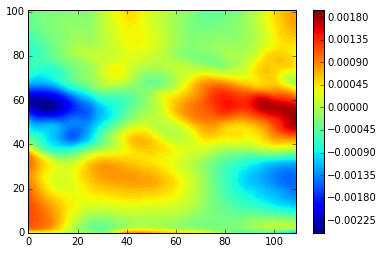

In [125]:
calibration = np.nanmean(mean_sub_u, axis=-1)
plt.contourf(calibration, 100)
plt.colorbar()

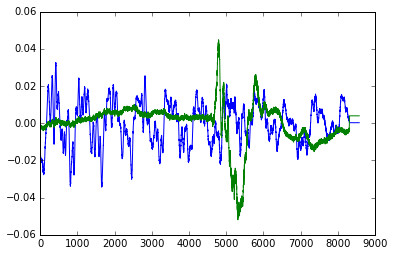

In [133]:
ica = FastICA(n_components=2)

Sa = mean_sub_u[:, 0].reshape((-1, mean_sub_u.shape[-1]))
Sa[np.isnan(Sa)] = 0

Xa = ica.fit_transform(Sa.T)

plt.plot(Xa)

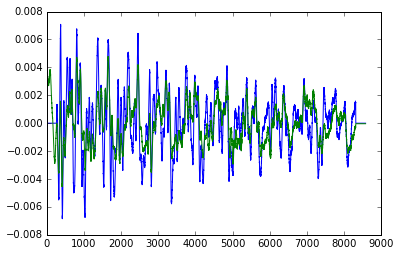

In [171]:
ica_signal = Xa[:, 0]
ref_signal = signals14[-1]

A = np.vstack([ica_signal, np.ones(ica_signal.size)]).T
scaling, c = np.linalg.lstsq(A, ref_signal)[0]

plt.plot(ref_signal)
plt.plot(ica_signal * scaling)

scale_ica = ica_signal * scaling

<matplotlib.contour.QuadContourSet instance at 0x2ae89e233098>

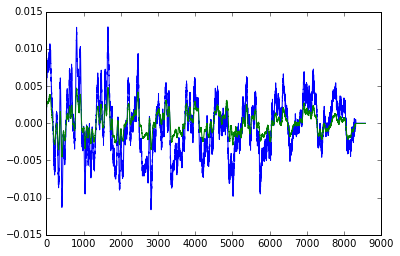

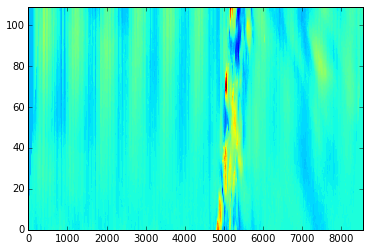

In [187]:
plt.plot(mean_sub_u[-1, 1, :])
plt.plot(scale_ica)
plt.figure()
plt.contourf((mean_sub_u - scale_ica * 2)[70, :], 100)

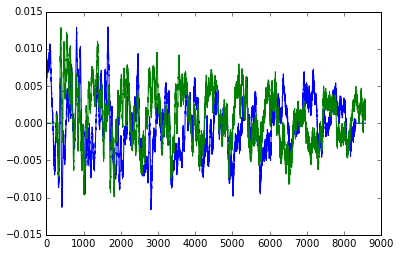

In [185]:
simple_signal = mean_sub_u[-1, 1, :]
another_simple_signal = mean_sub_u[-1, -1, :]
plt.plot(simple_signal)
plt.plot(another_simple_signal)
#plt.contourf((mean_sub_u - simple_signal)[:, 50], 100)

<matplotlib.colorbar.Colorbar instance at 0x2ae866bef7a0>

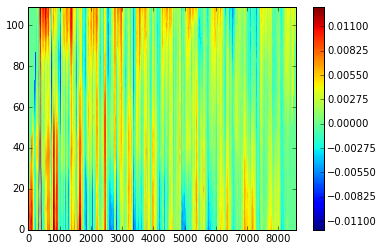

In [186]:
plt.contourf(mean_sub_u[-1, :, :], 100)
plt.colorbar()

<matplotlib.contour.QuadContourSet instance at 0x2ae78c1f6128>

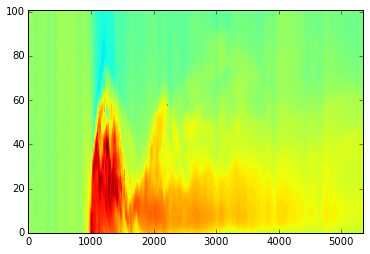

In [174]:
plt.contourf(sub_runs[0].U[:, 1], 100)

(40, 50)

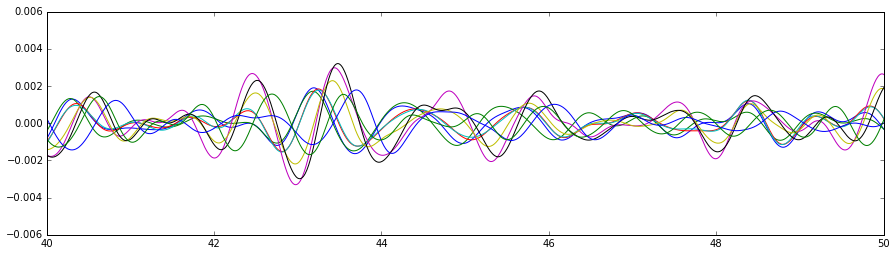

In [50]:
plt.figure(figsize=(15, 4))
for fsignal in fsignals:
    time = sub_runs[0].T[0, 0]
    plt.plot(time, fsignal)
    
for time, fsignal in zip(time14, fsignals14):
    plt.plot(time, fsignal)
    
plt.xlim(40, 50)

In [14]:
def plot_run(r):
    signal = np.mean(r.U[-10:, :, :], axis=0).mean(axis=0)[:4000]
    t = r.T[0, 0, :4000]
    plt.figure()
    plt.plot(t, signal)
    
    plt.figure()
    fft = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(signal.size, d=0.01)
    plt.semilogx(freqs, np.abs(fft))

/nfs/see-fs-02_users/eeaol/src/anaconda/envs/thesis/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


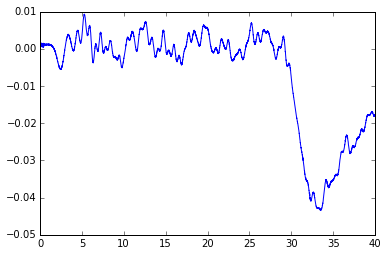

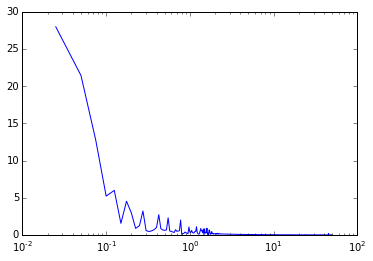

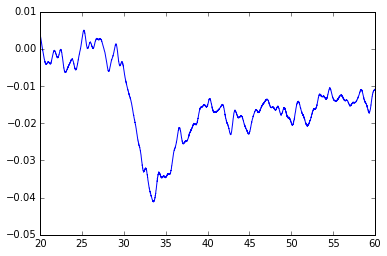

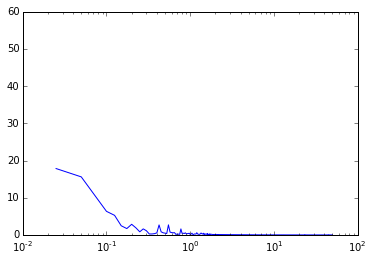

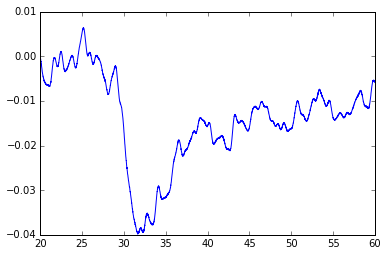

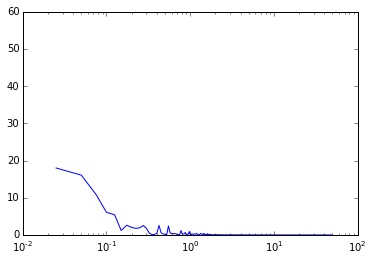

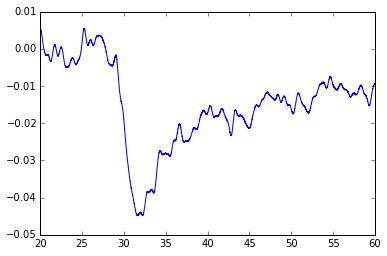

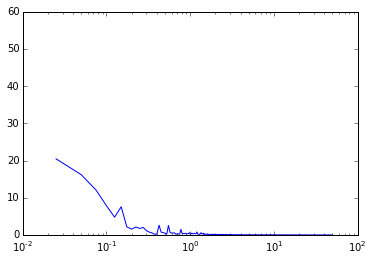

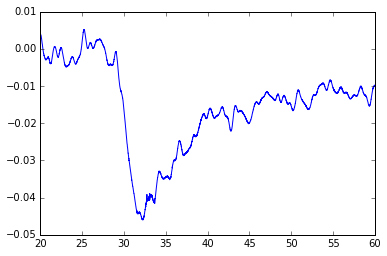

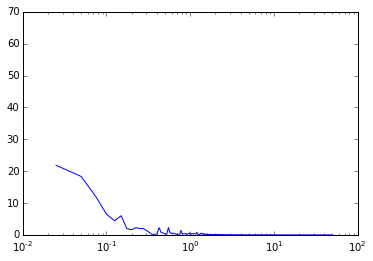

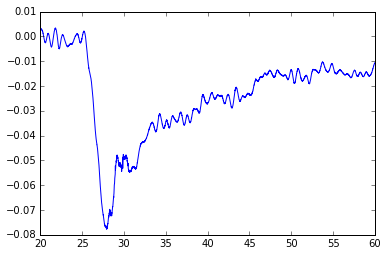

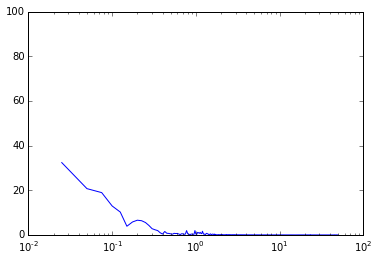

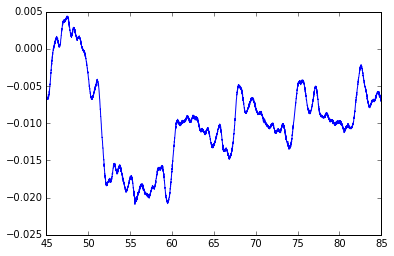

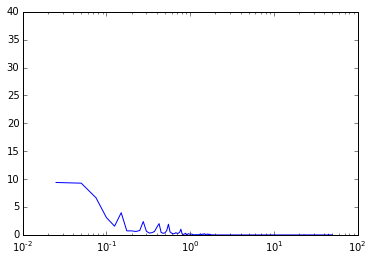

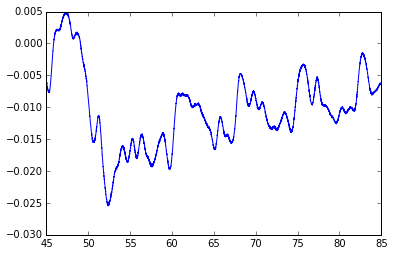

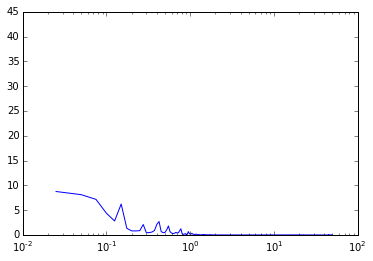

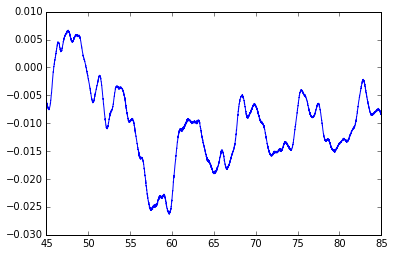

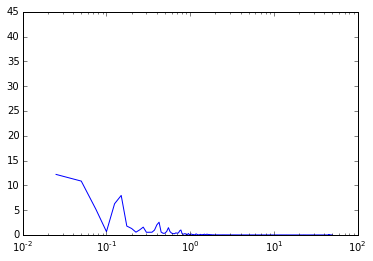

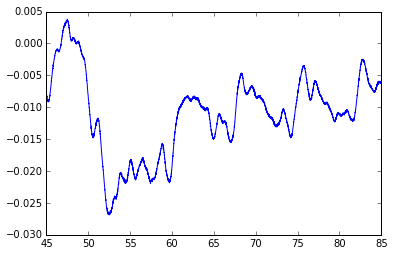

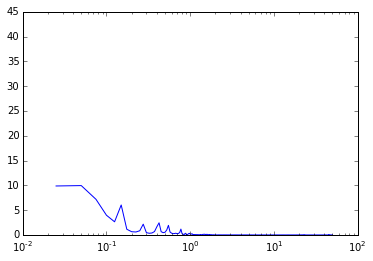

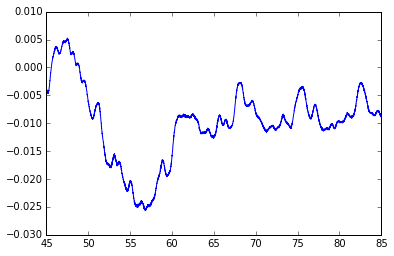

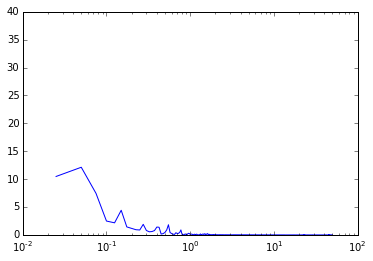

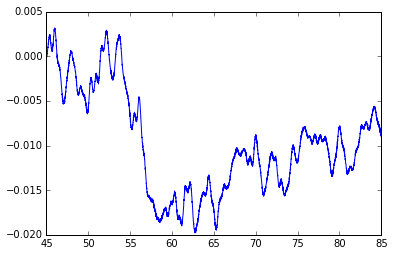

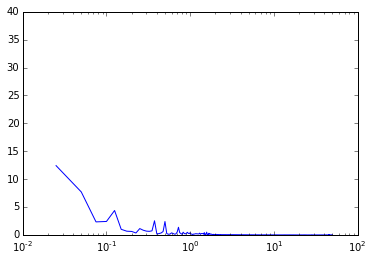

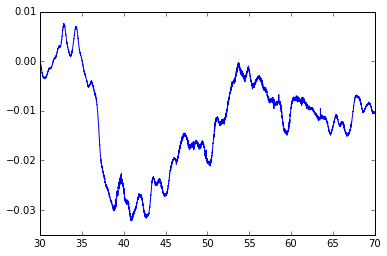

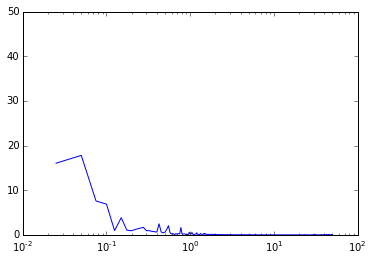

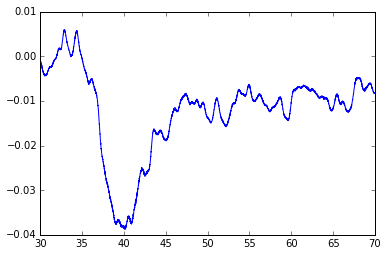

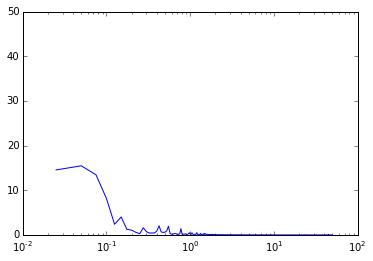

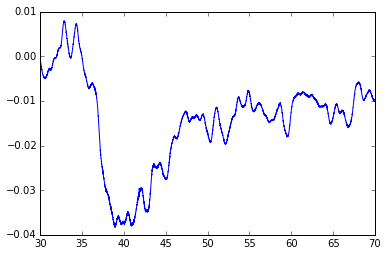

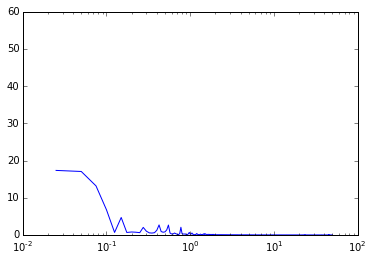

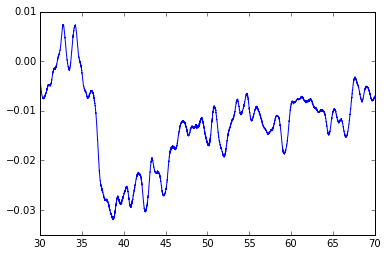

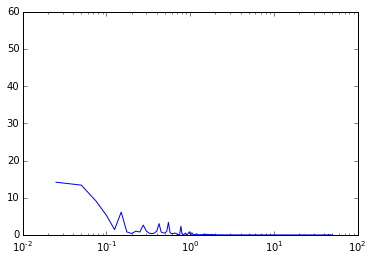

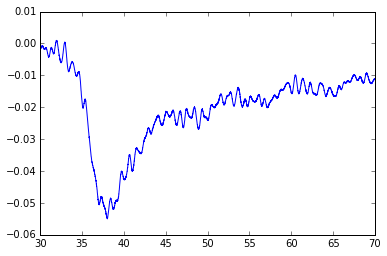

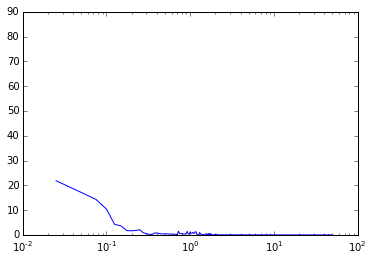

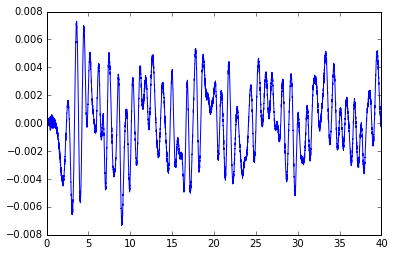

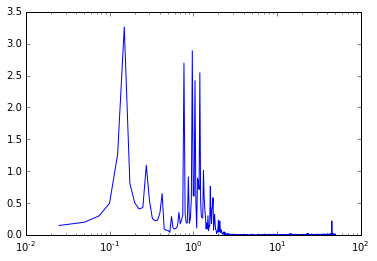

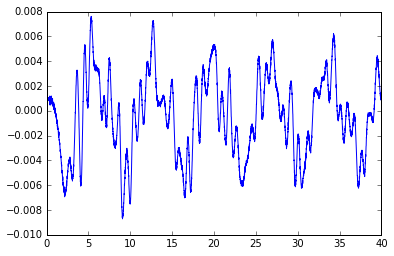

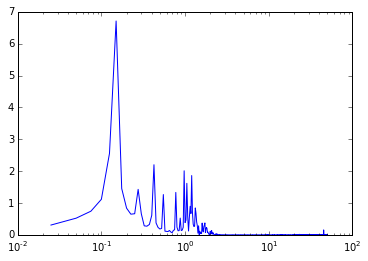

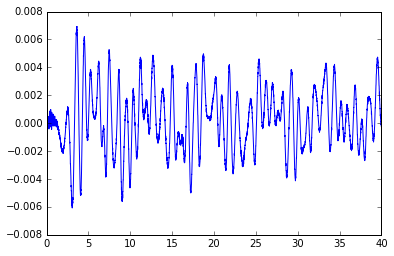

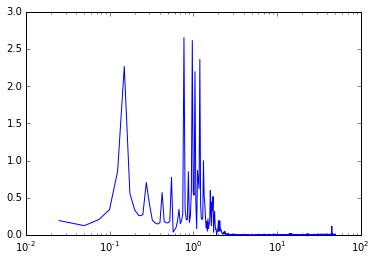

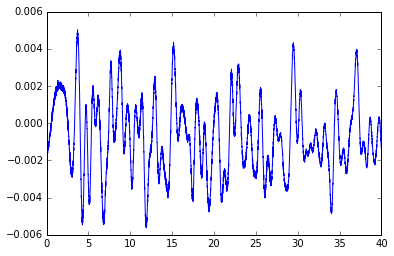

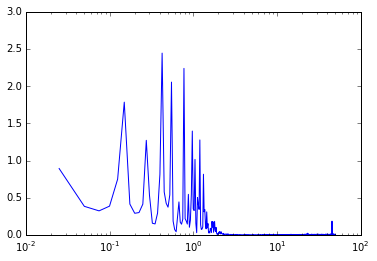

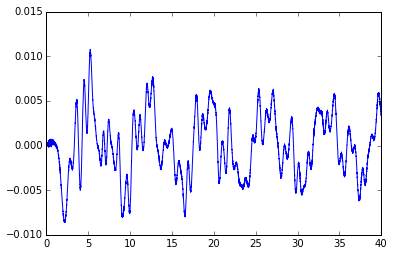

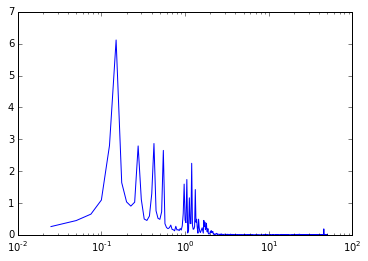

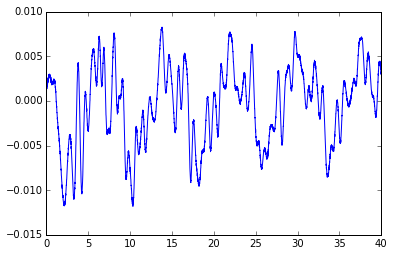

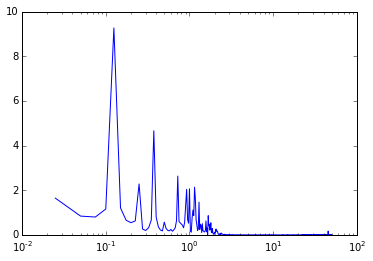

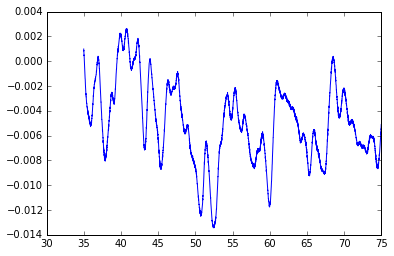

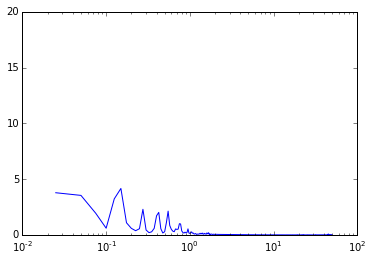

In [15]:
for run in runs:
    plot_run(run)

In [16]:
len(runs)

24

In [ ]:
def wavelet_run(r):
    